In [1]:
import requests
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rasterio as rs

from shapely.geometry import Polygon
from rasterio.mask import mask
import plotly.graph_objects as go

%matplotlib notebook


In [77]:
class Address:
    def __init__(self,street_name,house_number,post_code):
        self.street = street_name
        self.house_nr = house_number
        self.postcode = post_code
        self.df = pd.read_csv("bounding_box.csv",sep = "\t")
        
    
        self.dsm_dtm_address = None
        self.dsm_url = None
        self.dsm = None
        self.dsm_raster = None
        self.dtm_url = None
        self.dtm = None
        self.dtm_raster = None
        self.shape_poly = None
        self.chm = None
    
    def get_x_coordinate(self):
            response_API = requests.get('https://api.basisregisters.vlaanderen.be/v1/adresmatch',
                                    params= {'straatnaam':self.street ,
                                             'huisnummer':self.house_nr , 
                                             'postcode': self.postcode} ).json()


            coordinates = response_API['adresMatches'][0]['adresPositie']['point']['coordinates']
            x = coordinates[0]
            y = coordinates[1]

            gebouweenheden = requests.get(response_API['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
            gebouw = requests.get(gebouweenheden['gebouw']['detail']).json()
            polygon_list = gebouw['geometriePolygoon']['polygon']['coordinates'][0]
            return coordinates[0]

        
        
    def get_y_coordinate(self):
            response_API = requests.get('https://api.basisregisters.vlaanderen.be/v1/adresmatch',
                                        params= {'straatnaam':self.street ,
                                                 'huisnummer':self.house_nr , 
                                                 'postcode': self.postcode} ).json()


            coordinates = response_API['adresMatches'][0]['adresPositie']['point']['coordinates']
            x = coordinates[0]
            y = coordinates[1]

            gebouweenheden = requests.get(response_API['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
            gebouw = requests.get(gebouweenheden['gebouw']['detail']).json()
            polygon_list = gebouw['geometriePolygoon']['polygon']['coordinates'][0]
            return coordinates[1]
        
        
    


    def get_details(self):
        response_API = requests.get('https://api.basisregisters.vlaanderen.be/v1/adresmatch',
                                params= {'straatnaam':self.street ,
                                         'huisnummer':self.house_nr , 
                                         'postcode': self.postcode} ).json()


        coordinates = response_API['adresMatches'][0]['adresPositie']['point']['coordinates']
        x = self.get_coordinates()[0]
        y = self.get_coordinates()[1]

        gebouweenheden = requests.get(response_API['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
        gebouw = requests.get(gebouweenheden['gebouw']['detail']).json()
        polygon_list = gebouw['geometriePolygoon']['polygon']['coordinates'][0]
        return response_API
    
    def get_polygon(self): 
        response_API = requests.get('https://api.basisregisters.vlaanderen.be/v1/adresmatch',
                                params= {'straatnaam':self.street ,
                                            'huisnummer':self.house_nr , 
                                            'postcode': self.postcode} ).json()


        coordinates = response_API['adresMatches'][0]['adresPositie']['point']['coordinates']
        x = coordinates[0]
        y = coordinates[1]

        gebouweenheden = requests.get(response_API['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
        gebouw = requests.get(gebouweenheden['gebouw']['detail']).json()
        polygon_list = gebouw['geometriePolygoon']['polygon']['coordinates'][0]
        return polygon_list
        
        
        
    def open_adress_tiff_url(self):
        x_cor = self.get_x_coordinate()
        y_cor = self.get_y_coordinate()
        
        for i in range(len(self.df)):

            if self.df.top[i]>=y_cor and  self.df.bottom[i]<= y_cor \
            and self.df.left[i]<=x_cor and self.df.right[i]>=x_cor:
                print(f"{self.df.top[i]}>{y_cor} and {self.df.bottom[i]}<={y_cor} \
                        and {self.df.left[i]}<={x_cor} and {self.df.right[i]}>={x_cor} i: {i}")

                if i<10:
                    page_num = str(i) + ".zip"
                    page_num2 = str(i)+ ".tif"

                    url_DSM_DTM = {
                            "dsm":
                            "zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k0" + page_num \
                           +"!/GeoTIFF/DHMVIIDSMRAS1m_k0"+page_num2,

                            "dtm":
                            "zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k0" + page_num \
                           +"!/GeoTIFF/DHMVIIDSMRAS1m_k0"+page_num2 }

                else:
                    page_num = str(i+1) + ".zip"
                    page_num2 = str(i+1)+ ".tif"
                    url_DSM_DTM = {"dsm":
                        "zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k" + page_num \
                        +"!/GeoTIFF/DHMVIIDSMRAS1m_k"+page_num2,
                                   "dtm":
                        "zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k" + page_num \
                        +"!/GeoTIFF/DHMVIIDTMRAS1m_k"+page_num2
                                  }
                return url_DSM_DTM
        #             for key, value in files.items():
        #                 with urlopen(value) as zipresp:
        #                     print(f"Downloading {key} zip file")
        #                     with ZipFile(BytesIO(zipresp.read())) as zfile:
        #                         print(f"Extracting {key} zip file")
        #                         zfile.extractall(f'data/raster_files/{key}')
        #                 print(f"Done extracting the {key} zip file ")
        
        
    def read_adress_tiff(self):
        self.dsm_dtm_address = self.open_adress_tiff_url()
        print("got dsm_dtm_adress")
        self.dsm_url = self.dsm_dtm_address['dsm']
        self.dsm = rs.open(self.dsm_url)
        print("dsm read")

        self.dtm_url = self.dsm_dtm_address['dtm']
        self.dtm = rs.open(self.dtm_url)
        print("dtm read")

    def get_dsm(self):
        return self.dsm
    
    
    def get_dtm(self):
        return self.dtm


    def get_shape_poly(self):
        if self.shape_poly == None:
            self.shape_poly = Polygon(self.get_polygon())
        return self.shape_poly


    def calculate_chm(self):
        out_DSM_img, out_transform = mask(self.dsm,[self.get_shape_poly()], crop=True, nodata=0, filled=True, indexes=1)

        out_DTM_img, out_transform = mask(self.dtm,[self.get_shape_poly()], crop=True, nodata=0, filled=True, indexes=1)

        self.chm = out_DSM_img - out_DTM_img


    def get_chm(self):
        return self.chm

    def plot_3d(self):

        x = range(self.chm.shape[1])
        y = range(self.chm.shape[0])


        X,Y = np.meshgrid(x,y)
        hf = plt.figure(figsize=(10,10))
        ha = hf.add_subplot(111,projection = '3d')


        ha.plot_surface(X,Y,self.get_chm(),cmap = "twilight")
        plt.show()


    def go_plot(self):
        fig = go.Figure(data=go.Surface (z= self.get_chm() , opacity=0.9, colorscale='geyser'))
                  

        fig.update_layout(scene = dict(
                    xaxis_title='X AXIS TITLE',
                    yaxis_title='Y AXIS TITLE',
                    zaxis_title='Z AXIS TITLE'),
                    width=700,
                    height = 700
                  )

        fig.show()






In [78]:
street_name = input("Enter the street name: ") 

Enter the street name: Koningin Astridplein 


In [79]:
house_number = input("Enter the house number: ") 

Enter the house number: 27


In [80]:
post_code = input("Enter the postcode: ") 

Enter the postcode: 2018


In [81]:
adress1 = Address(street_name,house_number,post_code)

In [82]:
adress1.open_adress_tiff_url()

218000.0>211936.39 and 198000.0<=211936.39                         and 130000.0<=153660.11 and 162000.0>=153660.11 i: 14


{'dsm': 'zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k15.zip!/GeoTIFF/DHMVIIDSMRAS1m_k15.tif',
 'dtm': 'zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k15.zip!/GeoTIFF/DHMVIIDTMRAS1m_k15.tif'}

In [83]:
adress1.read_adress_tiff()

218000.0>211936.39 and 198000.0<=211936.39                         and 130000.0<=153660.11 and 162000.0>=153660.11 i: 14
got dsm_dtm_adress
dsm read
dtm read


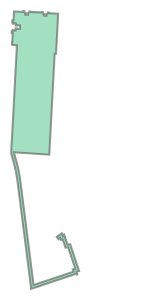

In [84]:
adress1.get_shape_poly()

In [85]:
adress1.get_dsm()

<open DatasetReader name='zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k15.zip!/GeoTIFF/DHMVIIDSMRAS1m_k15.tif' mode='r'>

In [86]:
adress1.get_dtm()

<open DatasetReader name='zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k15.zip!/GeoTIFF/DHMVIIDTMRAS1m_k15.tif' mode='r'>

In [ ]:
adress1.calculate_chm()

In [73]:
adress1.get_chm()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<IPython.core.display.Javascript object>


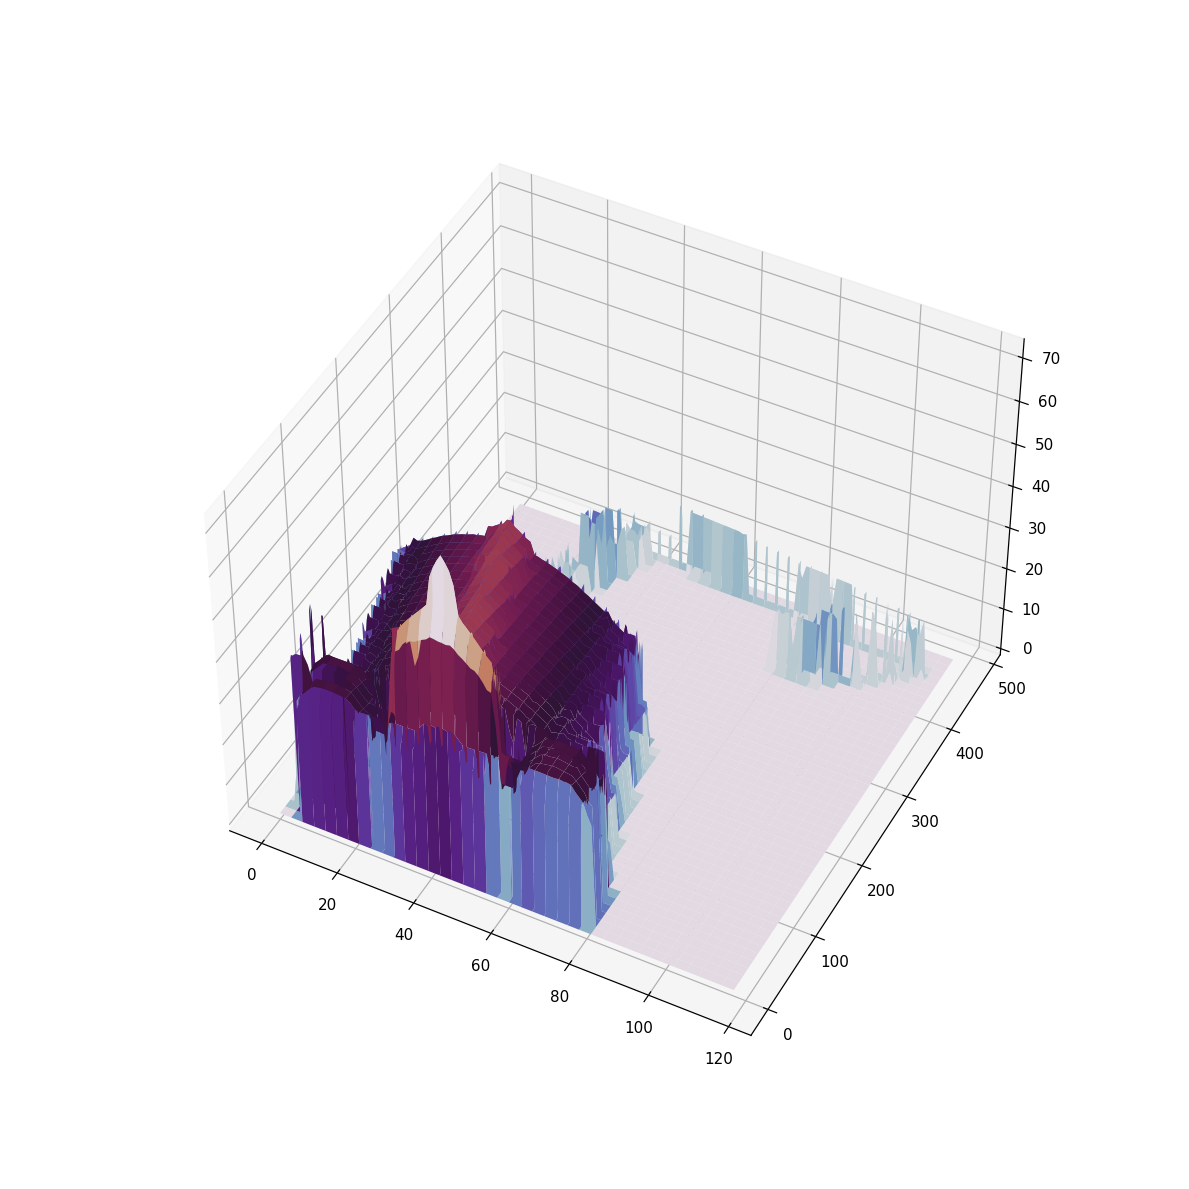

In [74]:
adress1.plot_3d()

In [76]:
adress1.go_plot()

NameError: name 'chm' is not defined